In [31]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from datetime import datetime, time
import zoneinfo

import polars as pl
import matplotlib.pyplot as plt

from strategies.sma import preprocess_asset, catch_up, get_featurizers
from src.data.index import CandlesAssetData

In [39]:
asset = CandlesAssetData.from_polars((
    # pl.read_parquet("../tests/static/T.parquet")
    pl.read_parquet("../data/candles_1_min/RUAL.parquet")
    .filter(pl.col("ts") >= datetime(2025, 1, 1, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    # .filter(pl.col("ts") <= datetime(2025, 2, 1, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    .filter(pl.col("ts").dt.weekday() <= 5)
    .filter(pl.col("ts").dt.time() >= time(7))
))

len(asset)

17205

In [40]:
catch_up(asset, featurizers=get_featurizers())

17205it [00:00, 3343975.92it/s]
17205it [00:00, 4530006.30it/s]
17205it [00:00, 4470234.80it/s]
17205it [00:00, 4342198.71it/s]
17205it [00:00, 4413639.16it/s]
17205it [00:00, 4668629.12it/s]
17205it [00:00, 4476890.65it/s]
17205it [00:00, 4370072.08it/s]
17205it [00:00, 4515549.74it/s]
17205it [00:00, 4520358.33it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17205/17205 [00:32<00:00, 523.84it/s]


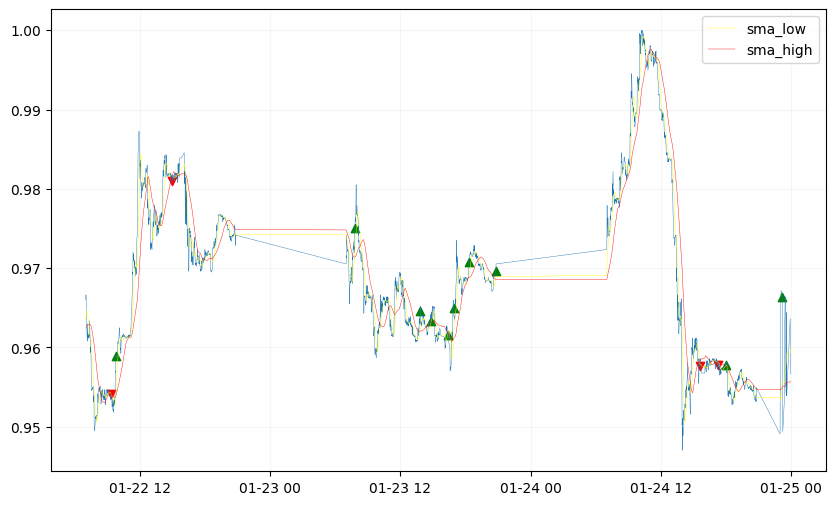

In [44]:
sma_low = "sma_15"
sma_high = "sma_60"

dd = (
    asset.to_polars()
    .filter(pl.col("ts") >= datetime(2025, 1, 22, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    .filter(pl.col("ts") <= datetime(2025, 1, 25, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    .select("ts", "close", pl.col("is_entry").cast(bool), pl.col("is_exit").cast(bool), sma_low, sma_high, f"{sma_low}_lag", f"{sma_high}_lag")
    .to_pandas()
)


fig, ax = plt.subplots(figsize=(10, 6))

norm = dd["close"].max()
ax.plot(dd["ts"], dd["close"] / norm, linewidth=0.3)
ax.plot(dd["ts"], dd[sma_low] / norm, linewidth=0.3, color="yellow", label="sma_low")
ax.plot(dd["ts"], dd[sma_high] / norm, linewidth=0.3, color="red", label="sma_high")
ax.scatter(
    dd.query("is_entry")["ts"],
    dd.query("is_entry")["close"] / norm,
    color="green",
    marker="^"
)
ax.scatter(
    dd.query("is_exit")["ts"],
    dd.query("is_exit")["close"] / norm,
    color="red",
    marker="v"
)

ax.grid(alpha=0.1)
ax.legend()

# Detailed boosting features

In [121]:
data = asset.get_last_n_ticks(asset.sorted_dates[40000], n_ticks=1000)
df = pl.from_dicts(data)
df

open,high,low,close,volume,ts,instrument_id,parse_ts,lot,sma_60,sma_60_lag,sma_15,sma_15_lag,volatility_15,volatility_30,volatility_60,volatility_120,sma_30,sma_120,sma_15_lag_5,sma_30_lag_5,sma_60_lag_5,sma_120_lag_5,close_lag_1,close_lag_5,close_lag_15,volume_lag_1,volume_lag_5,volume_lag_15,diff_sma_15_sma_15_lag_5,diff_sma_30_sma_30_lag_5,diff_sma_60_sma_60_lag_5,diff_sma_120_sma_120_lag_5,diff_volume_lag_5_volume_lag_1,diff_close_lag_5_close_lag_1,is_entry,is_exit
f64,f64,f64,f64,i64,"datetime[μs, UTC]",str,datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,i64,f64,i64,bool
322.4,322.6,321.2,321.4,150225,2025-01-15 07:39:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,314.53,314.316667,322.293333,322.133333,0.442422,0.385496,0.287789,0.207571,318.54,312.015,320.6,316.893333,313.436667,311.483333,322.2,323.0,320.0,38785,100503,281348,1.693333,1.646667,1.093333,0.531667,61718,0.8,0,false
321.4,322.4,321.0,322.4,60830,2025-01-15 07:40:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,314.726667,314.53,322.386667,322.293333,0.442995,0.388093,0.290957,0.209983,318.833333,312.113333,321.0,317.233333,313.663333,311.591667,321.4,322.2,319.4,150225,97674,145053,1.386667,1.6,1.063333,0.521667,-52551,0.8,0,false
322.4,322.4,321.8,322.2,31398,2025-01-15 07:41:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,314.94,314.726667,322.586667,322.386667,0.441129,0.388468,0.292458,0.211206,319.186667,312.22,321.386667,317.586667,313.876667,311.695,322.4,322.6,320.6,60830,66772,215172,1.2,1.6,1.063333,0.525,5942,0.2,0,false
322.2,323.0,322.2,322.8,40059,2025-01-15 07:42:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,315.15,314.94,322.693333,322.586667,0.424391,0.38196,0.290866,0.211128,319.52,312.325,321.813333,317.926667,314.096667,311.801667,322.2,322.6,323.0,31398,26587,248455,0.88,1.593333,1.053333,0.523333,-4811,0.4,0,false
322.8,323.0,322.2,322.4,19548,2025-01-15 07:43:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,315.37,315.15,322.68,322.693333,0.411884,0.376802,0.289617,0.211045,319.846667,312.436667,322.133333,318.233333,314.316667,311.91,322.8,322.2,322.6,40059,38785,226940,0.546667,1.613333,1.053333,0.526667,-1274,-0.6,0,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
338.8,338.8,338.6,338.6,2538,2025-01-16 10:43:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,338.99,339.003333,339.0,339.0,0.113929,0.134632,0.167088,0.195471,339.1,339.238333,339.093333,339.2,339.11,339.286667,338.8,338.8,338.6,2191,9721,18808,-0.093333,-0.1,-0.12,-0.048333,7530,0.0,1,false
338.6,339.4,338.6,338.8,23069,2025-01-16 10:44:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,338.973333,338.99,339.0,339.0,0.110334,0.13219,0.165385,0.194449,339.073333,339.226667,339.066667,339.186667,339.086667,339.27,338.6,338.8,339.0,2538,4686,8014,-0.066667,-0.113333,-0.113333,-0.043333,2148,0.2,0,false
339.0,339.6,339.0,339.4,10257,2025-01-16 10:45:00 UTC,"""b71bd174-c72c-41b0-a66f-5f9073…",2025-02-03 21:53:31.707402,1,338.963333,338.973333,338.986667,339.0,0.118659,0.135579,0.166468,0.194682,339.053333,339.221667,339.08,339.166667,339.066667,339.261667,338.8,338.6,339.4,23069,15914,9457,-0.093333,-0.113333,-0.103333,-0.04,-7155,-0.2,0,false


<Axes: >

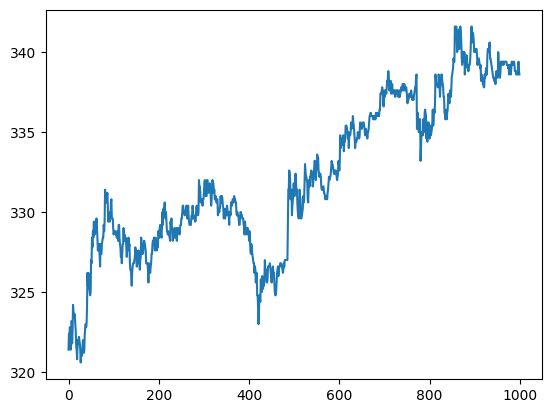

In [123]:
df["close"].to_pandas().plot()

## 1. Тренд за разные лаги:

2 * (price - price_lag) / (price + price_lag)

или аналогичное на коротких sma

In [ ]:
from src.features.func import FuncFeaturizer


def window_max(asset: CandlesAssetData, dt: datetime, window_size: int = 60, col: str = "close"):
    data = asset.get_last_n_ticks(dt, window_size)

    if len(data) == 0:
        return None

    return max([d[col] for d in data])


def window_min(asset: CandlesAssetData, dt: datetime, window_size: int = 60, col: str = "close"):
    data = asset.get_last_n_ticks(dt, window_size)

    if len(data) == 0:
        return None

    return min([d[col] for d in data])

